In [1]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import seaborn as sns

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display
from google.colab import auth
from google.cloud import storage
import pandas as pd
import cv2
import numpy as np
import urllib.request as urllib
from tqdm import tqdm
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import torch.nn as nn
import torch
from time import perf_counter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, top_k_accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import wandb
import pickle

In [ ]:
tf.config.run_functions_eagerly(True)

# Generate Pose Embeddings with Movenet

In [3]:

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

### Load Model from TF Hub

In [4]:
# @title
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

### Fetch Yoga Images from GCS

Now, we will load all images from GCS and display the pose overlay detected by MoveNet on a sample image.

In [53]:
auth.authenticate_user()

In [54]:
bucket_name = 'ai-yoga-trainer-data'
storage_client = storage.Client(project='applied-ml-413816')
bucket = storage_client.get_bucket(bucket_name)
blob_names = [b.name for b in bucket.list_blobs(prefix='loaded/')]

In [55]:
metadata_blob_name = [b for b in blob_names if 'metadata.csv' in b][0]
metadata_df = pd.read_csv(f'gs://{bucket_name}/{metadata_blob_name}', index_col=0)

In [ ]:
image_blob_names = [b for b in blob_names if '.jpeg' in b]

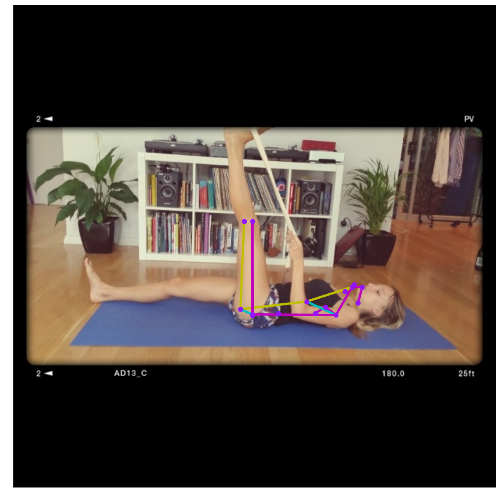

In [ ]:
url = f'https://storage.googleapis.com/{bucket_name}/{image_blob_names[5]}';
resp = urllib.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

cv2_imshow(cv2.resize(output_overlay, (500, 500)))

### Generate Pose Embeddings

Now, we will generated embeddings using the movenet classifier using the model initialized in [this](https://colab.research.google.com/drive/1uu5DWj7JJdK1ufLaYP1W9WF42iyrdWSM#scrollTo=BmvXp-llBjFh&line=1&uniqifier=1) cell.

In [57]:
def get_embeddings(image_blob_names):
  embeddings = []
  for blob_name in tqdm(image_blob_names):
    url = f'https://storage.googleapis.com/{bucket_name}/{blob_name}';
    resp = urllib.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    embeddings.append(keypoints_with_scores)

  embeddings_df = pd.DataFrame([e[0][0].flatten() for e in embeddings], columns=[f'{bp}_{feat}' for bp in KEYPOINT_DICT.keys() for feat in ['y', 'x', 'score']])
  embeddings_df['blob_name'] = image_blob_names
  return embeddings_df



In [ ]:
embeddings_df = get_embeddings(image_blob_names)

100%|██████████| 16767/16767 [37:46<00:00,  7.40it/s]


In [ ]:
embeddings_df.head()

,nose_y,nose_x,nose_score,left_eye_y,left_eye_x,left_eye_score,right_eye_y,right_eye_x,right_eye_score,left_ear_y,...,right_knee_y,right_knee_x,right_knee_score,left_ankle_y,left_ankle_x,left_ankle_score,right_ankle_y,right_ankle_x,right_ankle_score,blob_name
0,0.369896,0.301352,0.260206,0.350371,0.296303,0.320232,0.344436,0.291540,0.364636,0.366405,...,0.598117,0.396641,0.145493,0.636703,0.387519,0.215520,0.622042,0.401365,0.232737,loaded/0.jpeg
1,0.216861,0.409076,0.816147,0.187553,0.440200,0.617154,0.178483,0.385072,0.804289,0.200637,...,0.849157,0.220991,0.603120,0.737915,0.523411,0.345900,0.744636,0.481328,0.339098,loaded/1.jpeg
2,0.415345,0.799975,0.527386,0.394822,0.802332,0.385774,0.394220,0.790965,0.563723,0.400051,...,0.682818,0.883957,0.542786,0.732415,0.679969,0.291697,0.742536,0.702227,0.152706,loaded/10.jpeg
3,0.443831,0.628313,0.338997,0.437179,0.633262,0.381227,0.436785,0.638021,0.356547,0.454299,...,0.537059,0.474036,0.538618,0.419191,0.368362,0.464272,0.416025,0.371710,0.541014,loaded/100.jpeg
4,0.618385,0.251123,0.500477,0.627709,0.232040,0.351022,0.630743,0.236656,0.442467,0.660975,...,0.458721,0.702186,0.846795,0.657754,0.702909,0.717061,0.668186,0.706364,0.566248,loaded/1000.jpeg


Dump the embeddings to GCS.

In [ ]:
bucket.blob('loaded/pose_embeddings.csv').upload_from_string(embeddings_df.to_csv(index=False), 'text/csv')


# Train Classifier Using Input MoveNet Embeddings

Now, load the embeddings from GCS along with the metadata containing labels and source image paths.

In [ ]:
auth.authenticate_user()

In [58]:
bucket_name = 'ai-yoga-trainer-data'
storage_client = storage.Client(project='applied-ml-413816')
bucket = storage_client.get_bucket(bucket_name)

In [59]:
binary_stream = bucket.get_blob('loaded/pose_embeddings.csv').download_as_string()
embeddings_df = pd.read_csv(BytesIO(binary_stream))
binary_stream = bucket.get_blob('loaded/metadata.csv').download_as_string()
metadata_df = pd.read_csv(BytesIO(binary_stream), index_col=0)
metadata_df['image_path'] = metadata_df['image_path'].map(lambda x: x.split('./data/')[1].strip() if type(x) == str else x)

In [60]:
embeddings_df_w_labs = embeddings_df.merge(metadata_df[['pose_name_l3', 'pose_name_l2', 'pose_name_l1', 'image_path']], right_on='image_path', left_on='blob_name').drop(columns=['blob_name'])
embeddings_df_w_labs.head()

,nose_y,nose_x,nose_score,left_eye_y,left_eye_x,left_eye_score,right_eye_y,right_eye_x,right_eye_score,left_ear_y,...,left_ankle_y,left_ankle_x,left_ankle_score,right_ankle_y,right_ankle_x,right_ankle_score,pose_name_l3,pose_name_l2,pose_name_l1,image_path
0,0.369896,0.301352,0.260206,0.350371,0.296303,0.320232,0.344436,0.291540,0.364636,0.366405,...,0.636703,0.387519,0.215520,0.622042,0.401365,0.232737,Bharadvaja's Twist Pose,Legs-Behind,Sitting,loaded/0.jpeg
1,0.216861,0.409076,0.816147,0.187553,0.440200,0.617154,0.178483,0.385072,0.804289,0.200637,...,0.737915,0.523411,0.345900,0.744636,0.481328,0.339098,Bharadvaja's Twist Pose,Legs-Behind,Sitting,loaded/1.jpeg
2,0.415345,0.799975,0.527386,0.394822,0.802332,0.385774,0.394220,0.790965,0.563723,0.400051,...,0.732415,0.679969,0.291697,0.742536,0.702227,0.152706,Bharadvaja's Twist Pose,Legs-Behind,Sitting,loaded/10.jpeg
3,0.443831,0.628313,0.338997,0.437179,0.633262,0.381227,0.436785,0.638021,0.356547,0.454299,...,0.419191,0.368362,0.464272,0.416025,0.371710,0.541014,Boat Pose,Others,Wheel,loaded/100.jpeg
4,0.618385,0.251123,0.500477,0.627709,0.232040,0.351022,0.630743,0.236656,0.442467,0.660975,...,0.657754,0.702909,0.717061,0.668186,0.706364,0.566248,Bridge Pose,Up-Facing,Wheel,loaded/1000.jpeg


## Preprocess Embeddings

Before training, we need to preprocess the embeddings. Preprocessing involves the following steps:

1. Drop the landmark detection confidence scores obtained from MoveNet.
2. Normalize the landmark embeddings, which contain x and y coordinates for every detected landmark (17 total) for each image.
  1. Compute center of the pose by determining the midpoint between the left and right hip.
  2. Center the pose embedding by subtracting the pose center (computed above) from each landmark coordinate.
  3. Compute the size of the pose.
    1. Compute distances from each landmark coordinate to pose center and record the largest distance $d_max$.
    2. Compute torso length $torso_length$ (distance from pose center to center point of the left and right shoulder).
    3. Compute $max(torso_length*2.5, d_max)$.
  4. Normalize by dividing the centered pose embedding by the pose size.
3. Flatten the pose embedding into a vector.

In [61]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [62]:
def get_center_point_of_landmark(landmark_embeddings, left_bodypart, right_bodypart):
  left_x_y = landmark_embeddings[:, KEYPOINT_DICT[left_bodypart], :2]
  right_x_y = landmark_embeddings[:, KEYPOINT_DICT[right_bodypart], :2]
  center_x_y = (left_x_y + right_x_y) / 2
  return center_x_y

def get_pose_size(landmark_embeddings, torso_size_multiplier=2.5):
  # hips center
  hips_center_x_y = get_center_point_of_landmark(landmark_embeddings, 'left_hip', 'right_hip')

  # shoulders center
  shoulders_center_x_y = get_center_point_of_landmark(landmark_embeddings, 'left_shoulder', 'right_shoulder')

  # torso length as the minimum body size
  torso_size = np.linalg.norm(shoulders_center_x_y - hips_center_x_y, axis=1, keepdims=True)

  # pose center
  pose_center = hips_center_x_y
  pose_center = np.repeat(pose_center, 17, axis=0).reshape(landmark_embeddings.shape[0], -1, 2)
  distance_to_pose_center = np.linalg.norm(landmark_embeddings - pose_center, axis=2, keepdims=True)

  # max dist to pose center
  max_dist = np.amax(distance_to_pose_center, axis=1)

  # normalize scale
  pose_size = np.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size

def normalize_landmark_embeddings(landmark_embeddings):
  landmark_embeddings_centers = get_center_point_of_landmark(landmark_embeddings, 'left_hip', 'right_hip')
  landmark_embeddings_centers = np.repeat(landmark_embeddings_centers, 17, axis=0).reshape(landmark_embeddings.shape[0], -1, 2) # reshape
  landmark_embeddings_centered = landmark_embeddings - landmark_embeddings_centers
  pose_size = get_pose_size(landmark_embeddings_centered)
  return landmark_embeddings_centered / pose_size[:, None]

def process_landmark_embeddings(landmark_embeddings):
  landmark_embeddings = landmark_embeddings.reshape(-1, 17, 3) # reshape
  landmark_embeddings = landmark_embeddings[:, :, :2] # drop score

  # normalize landmarks
  landmark_embeddings_normalized = normalize_landmark_embeddings(landmark_embeddings)

  # flatten the normalized landmark coordinates into a vector
  landmark_embeddings_normalized = landmark_embeddings_normalized.reshape(landmark_embeddings_normalized.shape[0], -1, 1)

  return landmark_embeddings_normalized[:, :, 0]

In [63]:
X = embeddings_df_w_labs[embeddings_df.drop(columns=['blob_name']).columns].values
X_scaled = process_landmark_embeddings(X)
y_l3 = embeddings_df_w_labs['pose_name_l3'].values
y_l2 = embeddings_df_w_labs['pose_name_l3'].values
y_l1 = embeddings_df_w_labs['pose_name_l3'].values

## Train Classifier

Create train, test, and validation splits.

In [64]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test_no_val, y_train, y_test_no_val, ind_train, ind_test_no_val = train_test_split(X_scaled, y_l3, embeddings_df_w_labs.index, test_size=1-train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test, ind_val, ind_test = train_test_split(X_test_no_val, y_test_no_val, ind_test_no_val, test_size=test_ratio/(test_ratio+validation_ratio))

In [89]:
lb = LabelBinarizer()
y_train_dummy = lb.fit_transform(y_train)
y_val_dummy = lb.fit_transform(y_val)
y_test_dummy = lb.transform(y_test)
y_test_no_val_dummy = lb.transform(y_test_no_val)

In [90]:
with open('./lb.pkl', 'wb') as f:
  pickle.dump(lb, f)

Below, we will train a classifier with the processed MoveNet embeddings as input and the class as an output. We will use TensorFlow to start.

### Keras

In [ ]:
model = Sequential([
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(lb.classes_.shape[0], activation='softmax')
])

model.build(X_train.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (13360, 128)              4480      
                                                                 
 dropout_2 (Dropout)         (13360, 128)              0         
                                                                 
 dense_4 (Dense)             (13360, 64)               8256      
                                                                 
 dropout_3 (Dropout)         (13360, 64)               0         
                                                                 
 dense_5 (Dense)             (13360, 82)               5330      
                                                                 
Total params: 18066 (70.57 KB)
Trainable params: 18066 (70.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# store checkpoint with highest acc
checkpoint_path = "weights.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20)

# Start training
history = model.fit(X_train, y_train_dummy, epochs=20, batch_size=16, validation_data=(X_val, y_val_dummy), callbacks=[checkpoint, earlystopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


782/783 [============================>.] - ETA: 0s - loss: 3.9072 - accuracy: 0.0826
Epoch 1: val_accuracy improved from -inf to 0.23553, saving model to weights.best.hdf5
783/783 [==============================] - 39s 47ms/step - loss: 3.9062 - accuracy: 0.0830 - val_loss: 3.2592 - val_accuracy: 0.2355
Epoch 2/20
  3/783 [..............................] - ETA: 27s - loss: 3.7640 - accuracy: 0.2083

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


783/783 [==============================] - ETA: 0s - loss: 3.3587 - accuracy: 0.1662
Epoch 2: val_accuracy improved from 0.23553 to 0.31257, saving model to weights.best.hdf5
783/783 [==============================] - 34s 43ms/step - loss: 3.3587 - accuracy: 0.1662 - val_loss: 2.8906 - val_accuracy: 0.3126
Epoch 3/20
782/783 [============================>.] - ETA: 0s - loss: 3.1349 - accuracy: 0.2094
Epoch 3: val_accuracy improved from 0.31257 to 0.35210, saving model to weights.best.hdf5
783/783 [==============================] - 33s 43ms/step - loss: 3.1349 - accuracy: 0.2093 - val_loss: 2.6781 - val_accuracy: 0.3521
Epoch 4/20
782/783 [============================>.] - ETA: 0s - loss: 2.9876 - accuracy: 0.2498
Epoch 4: val_accuracy improved from 0.35210 to 0.37764, saving model to weights.best.hdf5
783/783 [==============================] - 34s 44ms/step - loss: 2.9876 - accuracy: 0.2498 - val_loss: 2.5710 - val_accuracy: 0.3776
Epoch 5/20
782/783 [============================>.] - 

### PyTorch

PyTorch seems like a better implementation since we can easily integrate with Weights and Biases to save the training plots.

In [66]:
class ConfigDict(dict):
    def __getattr__(self, name):
        return self[name]

In [67]:
class Classifier(nn.Module):
  def __init__(self, dropout=0.5, activation='relu'):
    super(Classifier, self).__init__()
    self.linear1 = nn.Linear(34, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 82)
    self.dropout = nn.Dropout(dropout)
    if activation == 'relu':
      self.act = torch.relu
    elif activation == 'sigmoid':
      self.act = torch.sigmoid
    elif activation == 'tanh':
      self.act = torch.tanh
  def forward(self, x):
    x = self.act(self.linear1(x))
    x = self.dropout(x)
    x = self.act(self.linear2(x))
    x = self.dropout(x)
    x = self.linear3(x)
    return x

class PoseEmbeddingsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = {'embedding': self.X[idx], 'pose': self.y[idx]}
        return sample

def get_dataloader(X, y, config):
  dataset = PoseEmbeddingsDataset(X, y)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
  return dataloader

def build_opt(model, config):
  if config.optimizer == "sgd":
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=config.learning_rate, momentum=0.9)
  elif config.optimizer == "adam":
    optimizer = torch.optim.Adam(model.parameters(),
                               lr=config.learning_rate)
  return optimizer

def train_epoch(model, loader, optimizer, log_wandb):
  model.train()
  ce_loss = torch.nn.CrossEntropyLoss()
  cumu_loss = 0
  correct, total = 0, 0
  for i, batch in enumerate(loader):
    e, labels = batch['embedding'].to(device, dtype=torch.float32), batch['pose'].to(device, dtype=torch.float32)
    optimizer.zero_grad()

    # ➡ Forward pass
    outputs = model(e).to(device)
    loss = ce_loss(outputs, labels)
    cumu_loss += loss.item()

    # ⬅ Backward pass + weight update
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    _, labels = torch.max(labels, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    if log_wandb:
      wandb.log({"train_batch_loss": loss.item()})
      wandb.log({"train_batch_acc": correct / total})

  return cumu_loss / len(loader), correct / total

def test_epoch(model, loader, log_wandb):
  model.eval()
  ce_loss = torch.nn.CrossEntropyLoss()
  with torch.no_grad():
    cumu_loss = 0
    correct, total = 0, 0
    for i, batch in enumerate(loader):
      e, labels = batch['embedding'].to(device, dtype=torch.float32), batch['pose'].to(device, dtype=torch.float32)

      outputs = model(e)
      loss = ce_loss(outputs, labels)
      cumu_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      _, labels = torch.max(labels, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      if log_wandb:
        wandb.log({"test_batch_loss": loss.item()})
        wandb.log({"test_batch_acc": correct / total})

    return cumu_loss / len(loader), correct / total

def train(config=None, log_wandb=True, save_path=None, reinit=False):
  train_loader = get_dataloader(X_train, y_train_dummy, config)
  val_loader = get_dataloader(X_val, y_val_dummy, config)
  model = Classifier(config.dropout, config.activation).to(device)
  optimizer = build_opt(model, config)

  if log_wandb:
    # Initialize a new wandb run
    with wandb.init(config=config, project='movenet-yoga-classifier', reinit=reinit):
      # If called by wandb.agent, as below,
      # this config will be set by Sweep Controller
      config = wandb.config

      for epoch in tqdm(range(config.epochs)):
        start_train = perf_counter()
        train_avg_loss, train_acc = train_epoch(model, train_loader, optimizer, log_wandb)
        end_train = perf_counter()

        start_test = perf_counter()
        test_avg_loss, test_acc = test_epoch(model, val_loader, log_wandb)
        end_test = perf_counter()

        wandb.log({"train_time": end_train - start_train, "inference_time": end_test - start_test, "train_epoch_loss": train_avg_loss, "test_epoch_loss": test_avg_loss, "train_epoch_acc": train_acc, "test_epoch_acc": test_acc, "epoch": epoch})
  else:
    for epoch in tqdm(range(config.epochs)):
      train_avg_loss, train_acc = train_epoch(model, train_loader, optimizer, log_wandb)
      test_avg_loss, test_acc = test_epoch(model, val_loader, optimizer, log_wandb)
      print({"epoch": epoch, "train_time": end_train - start_train, "inference_time": end_test - start_test, "train_epoch_loss": train_avg_loss, "test_epoch_loss": test_avg_loss, "train_epoch_acc": train_acc, "test_epoch_acc": test_acc})

  if save_path:
    torch.save(model, save_path)

In [68]:
wandb.login(key='b7eb615af6a52dbae061d01b05800a4b6683b47c', force=True)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config = ConfigDict(epochs=5,
    batch_size=16,
    dropout=0.5,
    optimizer='adam',
    learning_rate=0.005,
    activation='relu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(config=config, log_wandb=True, reinit=True)

wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 5/5 [00:22<00:00,  4.60s/it]


epoch,▁▃▅▆█
inference_time,█▇▁▁▁
test_batch_acc,▂▁▁▁▁▁▁▂▁▄▄▃▃▄▄▄▂▄▄▄▄▄▄▅▇▆▆▆▇▆▆▆█▇▆▆▆▆▆▆
test_batch_loss,▄▅▄▆▄▄▅▇▄▅▃▄▃▄▄▃█▃▃▅▂▅▄▃▃▂▄▃▃▂▃▃▁▄▄▃▃▂▂▆
test_epoch_acc,▁▄▆██
test_epoch_loss,█▅▃▁▁
train_batch_acc,▁▂▂▃▃▄▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇███████████
train_batch_loss,█▇▇▅▄▅▆▅▄▆▆▂▂▃▆▄▅▃▅▃▄▅▅▁▅▁▇▄▂▅▁▂▃▃▃▂▅▃▂▃
train_epoch_acc,▁▅▆██
train_epoch_loss,█▄▂▂▁
train_time,▇▆█▁▁


## Tune Hyperparameters

In [ ]:
def sweep_train():
    # Set default values
    config = ConfigDict(epochs=10,
              batch_size=16,
              dropout=0.5,
              optimizer='adam',
              learning_rate=0.005,
              activation='relu')
    # Initialize wandb with a sample project name
    wandb.init(config=config, project='movenet-yoga-classifier')  # this gets over-written in the Sweep
    train(config=config)

In [ ]:
sweep_config = {
  'method': 'random',
  'metric': {
      'name': 'test_epoch_acc',
      'goal': 'maximize'
  },
  'early_terminate': {
      'type': 'hyperband',
      'min_iter': 5
  },
  'parameters': {
      'batch_size': {
          'values': [16, 32, 64, 128, 256]
      },
      'learning_rate': {
          'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]
      },
      'dropout': {
          'distribution': 'uniform',
          'max': 1.0,
          'min': 0
      },
      'optimizer': {
          'values': ['adam', 'sgd']
      },
      'activation': {
          'values': ['relu', 'sigmoid', 'tanh']
      },
  }
}

sweep_id = wandb.sweep(sweep_config, project="movenet-yoga-classifier")
wandb.agent(sweep_id, function=sweep_train, count=10)
wandb.finish()

Create sweep with ID: 8hka7sd9
Sweep URL: https://wandb.ai/aml-experiments/movenet-yoga-classifier/sweeps/8hka7sd9


wandb: Agent Starting Run: djwpz4j9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7234188200318172
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▅▁▆▂▂█▅▁▂▄
test_batch_acc,▁▁▁▁▇▃▃▃▅▅▅▅▅▅▅▅▅▅▆▅▆▆▇▆█▇▇▆▇▇▇▇▆▆▇▆▇▇▇▇
test_batch_loss,█▆▄▄▄▄▅▅▃▆▄▅▄▅▅▃▅▃▂▄▄▃▄▄▄▃▂▆▄▄▄▃▁▅▆▅▃▄▃▃
test_epoch_acc,▁▃▅▆▆▇██▇█
test_epoch_loss,█▅▄▄▃▂▁▁▁▁
train_batch_acc,▁▂▃▃▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇▇████████████████
train_batch_loss,█▇▆▃▂▃▆▆▄▃▂▅▂▃▅▃▃▄▃▃▃▃▁▂▁▁▄▄▆▂▄▃▂▅▃▁▃▄▅▆
train_epoch_acc,▁▅▅▆▇▇████
train_epoch_loss,█▄▃▃▂▂▂▁▁▁
train_time,█▂▁▂▁▁▃▂▂▃


wandb: Agent Starting Run: ly6g97y7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dropout: 0.9183320408235156
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▁▁▁▅▃▅▃▇▄█
test_batch_acc,▁▂▁▁▅▃▃▃▅▄▄▄▆▅▅▅▇▆▇▆▇▆▆▆▅▆▆▆█▆▆▆▆▇▆▆▆▆▆▆
test_batch_loss,▇▆▇▆▄▇▇▅▇▃▄▄▁▂▃▅▂▁▃▂▃▁▃▆▂▅▅▂▁▆▄▆▃▅█▄▃▆▄▇
test_epoch_acc,▁▃▅▆█▇▇███
test_epoch_loss,█▆▄▃▂▂▁▁▁▁
train_batch_acc,▁▂▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train_batch_loss,▆▆▅▅▂█▃▄▄▄▆▄▃▂▄▄▂▃▆▃▆▃▆▄▄▄▁▃▂▃▃▄▆▄▃▃▄▂▃▂
train_epoch_acc,▁▄▆▆▇▇████
train_epoch_loss,█▄▃▂▂▂▁▁▁▁
train_time,▂▁▁▇▂▂▃▂█▅


wandb: Agent Starting Run: f6bnoeyn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	dropout: 0.5053302128831818
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▁▁▆▁▅▅█▆▁▁
test_batch_acc,▃▂▂▂▇▃▃▃▁▄▄▄▄▆▆▆▆▆▆▆▆▇▇▇█▆▆▆▆▆▆▆▇▇▆▆█▇▇▇
test_batch_loss,▇▇▆█▄▇▅▄▄▄▄▃▄▂▇▂▆▆▆▅▅▆▄▂▁▄▄▅▆▂▄▅▅▁▅▄▆▅▂▅
test_epoch_acc,▁▃▄▆▆▇▆▇▇█
test_epoch_loss,█▅▅▄▃▂▂▁▂▁
train_batch_acc,▁▂▃▃▅▅▅▅▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_batch_loss,█▇▅▅▆▄▄▃▂▃▅▆▃▂▄▃▆▃▂▃▇▂▂▂▂▅▄▂▃▅▁▂▆▅▆▅▁▄▃▂
train_epoch_acc,▁▄▅▆▇▇▇█▇█
train_epoch_loss,█▄▃▂▂▂▁▁▁▁
train_time,▁▁▃▂▂█▅▂▂▁


wandb: Agent Starting Run: prit8pnj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dropout: 0.30281109802280726
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


 70%|███████   | 7/10 [00:33<00:14,  4.79s/it]
Traceback (most recent call last):
  File "<ipython-input-126-82d9b663389b>", line 116, in train
    train_avg_loss, train_acc = train_epoch(model, train_loader, optimizer, log_wandb)
  File "<ipython-input-126-82d9b663389b>", line 64, in train_epoch
    optimizer.step()
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/adam.py", line 166, in step
    adam(
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/adam.py", line 316, in adam
    func(params,
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/adam.py", line 565, in _multi_tensor_adam
    bias_correction1 = [1 - beta1 ** _get_value(step) for step in device_state_steps]
  File "/usr/local/lib/pyth

epoch,▁▂▃▅▆▇█
inference_time,▁█▁▄▂▇▂
test_batch_acc,▁▂▂▂▂▂▂▃▂▃▃▃▅▅▄▄▄▅▆▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▇
test_batch_loss,▄▄▄▄▅█▅▃▆▄▅▅▄▄▃▂▄▄█▅▄▄▂▄▄▁▅▁▂▃▁▂▂▃▃▂▄▄▄▅
test_epoch_acc,▁▃▅▆▇██
test_epoch_loss,█▅▄▃▁▂▁
train_batch_acc,▁▁▂▂▃▃▅▅▅▅▅▇▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█████
train_batch_loss,▆▆▆▄▆▁▃▃▄▁▅▃▄█▃▄▃▅▄▄▁▆▅▄▂▂▆▃▂▇▃▅▄▃▂▂▃▄▂▁
train_epoch_acc,▁▅▆▇▇██
train_epoch_loss,█▄▃▂▂▁▁
train_time,▃▅█▁▂█▅


wandb: Agent Starting Run: dn7z1n2o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2860592175691463
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▂▁▅▁▂▁▂▂█▅
test_batch_acc,▁▂▂▂▅▄▄▄▆▆▅▅▅▆▆▆▅▆▆▆▆▆▆▇▇▇▇▇▆▇▇▇██▇▇▇▆▇▇
test_batch_loss,▅▅█▇▅▆▆▆▆▄▅▃▄▅▄▆▁▆▃▃▅▄▂▂▁▃▄▄▂█▅▄▃▃▅▅▃▅▆▄
test_epoch_acc,▁▅▅▆▇▇▇▇██
test_epoch_loss,█▅▄▂▂▁▂▁▁▁
train_batch_acc,▁▂▂▃▅▅▅▅▇▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_batch_loss,█▅▄▃▅▆▅▅▂▅▆▄▃▃▄▂▇▂▄▄▃▁▃▄▄▃▅▂▃▆▃▄▇▃▃▄▂▂▄▂
train_epoch_acc,▁▄▅▆▇▇▇▇██
train_epoch_loss,█▄▃▃▂▂▂▂▁▁
train_time,▅▁▃▂▁▃▂▂█▅


wandb: Agent Starting Run: 25647wjg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.577192717846137
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▂▂▂▂▂█▁▂▂▂
test_batch_acc,▁▂▂▂▃▄▄▄▄▄▄▄▆▅▅▅▆▅▅▅▆▅▅▅▅▅▅▆▆▆▇▇██▇▇█▇▇▇
test_batch_loss,▆▇▆█▃▃▆▃▇▆▆▂▄▃▄▅▃▅▄▄▆▅▄▇▄▄▃▄▆▃▄▂▅▁█▃▃▅▅▂
test_epoch_acc,▁▄▄▅▅▆▆▇██
test_epoch_loss,█▅▄▄▃▂▂▂▁▁
train_batch_acc,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
train_batch_loss,█▆▅▅▅▄▄▅▁▂▄▃▃▄▄▂▃▆▁▁▂▃▃▂▄▅▄▂▆▁▃▄▃▄▂▆▂▅▁▃
train_epoch_acc,▁▄▆▆▆▇▇███
train_epoch_loss,█▄▃▂▂▂▁▁▁▁
train_time,▁▁█▂▁▅▄▁▁█


wandb: Agent Starting Run: 62dh94wt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 256
wandb: 	dropout: 0.19056572642287095
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▁▁▁█▁▁▂▂▁▁
test_batch_acc,▁▁▁▁▅▄▄▄▅▄▄▅▆▅▅▅▇▆▆▆▆▇▇▇▆▆▇▇▇▇▇▇▇███▇▇▇▇
test_batch_loss,▆█▇▆▇▄▅▅▄▆▂▅▅▃▄▃▅▄▅▆▅▃▄▅▂▃▂▃▂▁▄▆▂▄▂▃▆▅▅▆
test_epoch_acc,▁▃▄▅▆▇▇▇█▇
test_epoch_loss,█▅▄▃▃▂▂▁▁▁
train_batch_acc,▁▂▂▃▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_batch_loss,▆▄▆▅▅▃▄▅▃▄▄█▃▂▄▂▃▃▆▄▄▅▂▁▂▄▂▂▃▃▄▁▁▂▃▁▃▃▂▅
train_epoch_acc,▁▄▅▆▇▇▇▇██
train_epoch_loss,█▅▃▃▂▂▁▁▁▁
train_time,▆▁▁▂▅▂▁█▁▂


wandb: Agent Starting Run: m0ckkonk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2578927440840515
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▁█▁▁▁▂▁▁▅▂
test_batch_acc,▂▁▂▁▄▂▃▃▇▄▄▄▇▅▅▅▅▇▇▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇██▇▇█
test_batch_loss,▇█▅▆▆▆▂▃▃▅▅▅▅▅▃▆▃▆▃▇▃▃▆▄▃▄▃▂▇▃▄▆▅▂▆▁▃▅▂▄
test_epoch_acc,▁▃▄▅▆▇▆▇██
test_epoch_loss,█▅▄▃▂▂▂▁▁▁
train_batch_acc,▁▂▃▃▅▅▅▅▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇████
train_batch_loss,██▅▆▅▅▄▇▅▆▅▆▃▅▄▅▃▅▄▅▃▅▃▂▃▅▃▃█▃▅▅▂▂▁▄▆▃▅▂
train_epoch_acc,▁▄▅▆▆▇▇███
train_epoch_loss,█▄▃▂▂▂▂▁▁▁
train_time,▁▃▄▂▁█▂▁▅▂


wandb: Agent Starting Run: m76kzjie with config:
wandb: 	activation: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.3934277638505764
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▁▁▂▆▁▅▁▃█▅
test_batch_acc,▁▁▂▂▂▄▄▄▅▅▅▅█▆▆▆▄▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇
test_batch_loss,▅█▄▄▅▄▃▄▃▄▄▅▁▅▅▁▄▅▂▃▂▄▂▂▁▃▆▆▂▃▅▂▃▂▂▄▂▄▂▃
test_epoch_acc,▁▄▅▆▆▆▇███
test_epoch_loss,█▅▄▃▂▃▂▂▁▁
train_batch_acc,▁▂▂▃▅▅▅▅▇▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_batch_loss,▆▅▄▃▃▃▄▂▃▃▃▄▃▂▅▃▃▆▄▃█▃▃▁▂▁▅▂▂▅▂▂▄▃▃▄▃▂█▃
train_epoch_acc,▁▄▅▆▇▇▇███
train_epoch_loss,█▄▃▂▂▂▁▁▁▁
train_time,▃▁▁█▁▁▂▂▄▄


wandb: Agent Starting Run: lwk76fvj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.95024310853758
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


epoch,▁▂▃▃▄▅▆▆▇█
inference_time,▄█▂▁▄▂▃▅▇▁
test_batch_acc,▂▁▁▁▅▄▄▄▇▅▅▅▇▅▅▅▇▇▆▆▇▆▆▆▆▇▇▇▆▆▆▆█▇▇▇██▇█
test_batch_loss,▅▅▆█▇▄▇▃▃█▁▂▃▄▆▄▄▆▄▅▅▃▂▅▂▂▁▂▃▃▅▆▃▃▅▃▃▅▂▃
test_epoch_acc,▁▃▅▅▆▆▇▆▆█
test_epoch_loss,█▅▄▃▃▃▂▁▁▁
train_batch_acc,▁▂▃▃▅▅▅▅▅▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_batch_loss,█▇▅▆▃▄▄▅▆▄▄▄▅▅▅▂▃▃▄▄▄▇▃▃▄▃▄▄▅▃▁▃▅▂▃▁▂▃▅▃
train_epoch_acc,▁▄▅▆▇▇▇███
train_epoch_loss,█▄▃▂▂▂▁▁▁▁
train_time,█▇▁▁▆▁▄▇▄▇


## Train Best Model

In [69]:
config = ConfigDict(epochs=300,
    batch_size=256,
    dropout=0.39,
    optimizer='adam',
    learning_rate=0.005,
    activation='relu')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(config=config, log_wandb=True, save_path='./best_model')

wandb.finish()

wandb: Currently logged in as: ac5140 (aml-experiments). Use `wandb login --relogin` to force relogin


100%|██████████| 300/300 [02:49<00:00,  1.77it/s]
wandb: ERROR Control-C detected -- Run data was not synced


# Evaluate Model

In [28]:
model = Classifier()
model = torch.load('./best_model')

In [ ]:
def eval(model, loader):
  model.eval()
  true = []
  preds = []
  with torch.no_grad():
    for i, batch in enumerate(loader):
      e, labels = batch['embedding'].to(device, dtype=torch.float32), batch['pose'].to(device, dtype=torch.float32)
      true.append(labels)
      preds.append(model(e))
  return torch.cat(true, dim=0).detach().cpu().numpy(), torch.cat(preds, dim=0).detach().cpu().numpy()


In [ ]:
train_dataset = PoseEmbeddingsDataset(X_train, y_train_dummy)
test_dataset = PoseEmbeddingsDataset(X_test, y_test_dummy)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

{'acc': 0.6628343313373254, 'bal_acc': 0.6273395120725609}


<Axes: >

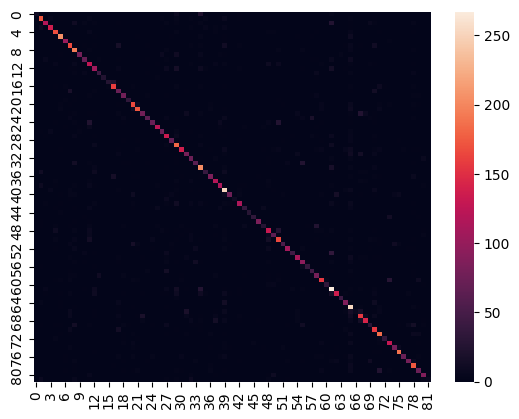

In [ ]:
train_true, train_preds = eval(model, train_dataloader)
train_true = train_true.argmax(axis=1)
train_preds = train_preds.argmax(axis=1)

train_metrics = {'acc': accuracy_score(train_true, train_preds),
                 'bal_acc': balanced_accuracy_score(train_true, train_preds)}
print(train_metrics)
cm = confusion_matrix(train_true, train_preds)
sns.heatmap(cm)

{'acc': 0.5976047904191617, 'bal_acc': 0.55749892550983}


<Axes: >

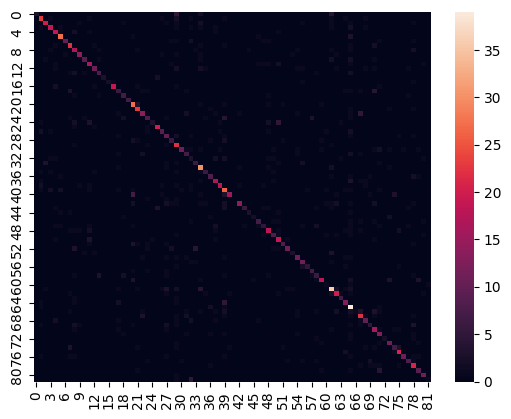

In [ ]:
test_true, test_preds = eval(model, test_dataloader)
test_true = test_true.argmax(axis=1)
test_preds = test_preds.argmax(axis=1)

test_metrics = {'acc': accuracy_score(test_true, test_preds),
                 'bal_acc': balanced_accuracy_score(test_true, test_preds)}
print(test_metrics)
cm = confusion_matrix(test_true, test_preds)
sns.heatmap(cm)

# Live Demo

In [6]:
def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
%cd 'drive/MyDrive/School/MS/Coursework/Spring 2024/AML/Final Project/Demo'
#%cd 'drive/MyDrive/Final Project/Demo'

/content/drive/MyDrive/School/MS/Coursework/Spring 2024/AML/Final Project/Demo


In [ ]:
cap = cv2.VideoCapture('sample1.mp4')
frames = []
success, image = cap.read()
while success:
  image = cv2.resize(image, (0, 0), fx = 0.3, fy = 0.3)

  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  embeddings = [movenet(input_image)]
  X = pd.DataFrame([e[0][0].flatten() for e in embeddings], columns=[f'{bp}_{feat}' for bp in KEYPOINT_DICT.keys() for feat in ['y', 'x', 'score']]).values
  X = process_landmark_embeddings(X)
  out = model(torch.from_numpy(X))
  out = out.detach().numpy()
  lab = lb.inverse_transform(out)[0]

  # # Visualize the predictions with image.
  display_image = tf.expand_dims(image, axis=0)
  display_image = tf.cast(tf.image.resize_with_pad(
  display_image, 1280, 1280), dtype=tf.int32)
  output_overlay = draw_prediction_on_image(
  np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

  BLACK = (255,255,255)
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_size = 1.1
  font_color = BLACK
  font_thickness = 2
  x,y = 250,200
  img_text = cv2.putText(output_overlay, lab, (x,y), font, font_size, font_color, font_thickness, cv2.LINE_AA)

  #cv2_imshow(cv2.resize(output_overlay, (500, 500)))

  frames.append(cv2.resize(output_overlay, (500, 500)))

  success, image = cap.read()